<a href="https://colab.research.google.com/github/avoy-mollick-bd/CVPR/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup & Imports




In [94]:
import os#avoy
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


2. Load Dataset

In [95]:
#from google.colab import files
#uploaded = files.upload()


3.Unzip The Loaded Dataset

In [96]:
'''import zipfile
import io

zip_ref = zipfile.ZipFile(io.BytesIO(uploaded["data.zip"]), 'r')
zip_ref.extractall("/content")
zip_ref.close()'''

'import zipfile\nimport io\n\nzip_ref = zipfile.ZipFile(io.BytesIO(uploaded["data.zip"]), \'r\')\nzip_ref.extractall("/content")\nzip_ref.close()'

4. Load + Convert to Grayscale + Resize + Flatten


In [97]:
data_path = "/content/data"

classes = ["cat", "dog", "panda"]
label_map = {"cat":0, "dog":1, "panda":2}

X = []
y = []

for cls in classes:
    folder = os.path.join(data_path, cls)#avoy
    for img_name in tqdm(os.listdir(folder), desc=f"Loading {cls}"):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).resize((32, 32))
            arr_rgb = np.array(img)

            R = arr_rgb[:, :, 0]
            G = arr_rgb[:, :, 1]
            B = arr_rgb[:, :, 2]

            gray = (0.299*R + 0.587*G + 0.114*B).astype(np.uint8)

            arr = gray.flatten()

            X.append(arr)
            y.append(label_map[cls])#avoy
        except:
            pass

X = np.array(X)
y = np.array(y)

print("Dataset Loaded:", X.shape, y.shape)


Loading panda: 100%|██████████| 100/100 [00:00<00:00, 117.64it/s]

Dataset Loaded: (299, 1024) (299,)


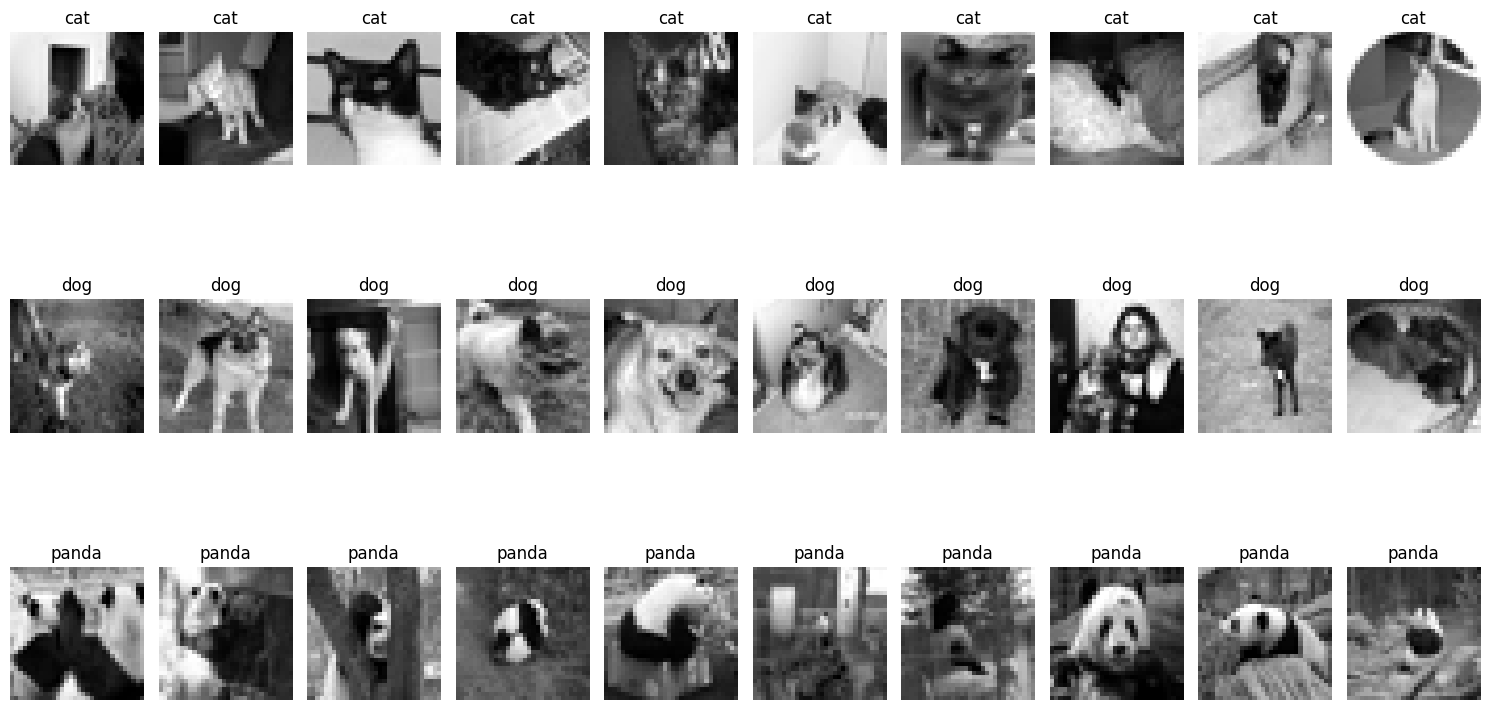

In [98]:
plt.figure(figsize=(15, 9))

images_per_class = 10
start_index = 1

for class_index, class_name in enumerate(classes):

    class_indices = np.where(y == class_index)[0]
    selected = np.random.choice(class_indices, images_per_class, replace=False)

    for j, idx in enumerate(selected):
        img = X[idx].reshape(32, 32)

        plt.subplot(len(classes), images_per_class, start_index)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")
        start_index += 1

plt.tight_layout()
plt.show()

5.Shuffle Dataset

In [99]:
idx = np.arange(len(X))
np.random.shuffle(idx)

X = X[idx]
y = y[idx]


6.Split into 5 folds

5-folds created.


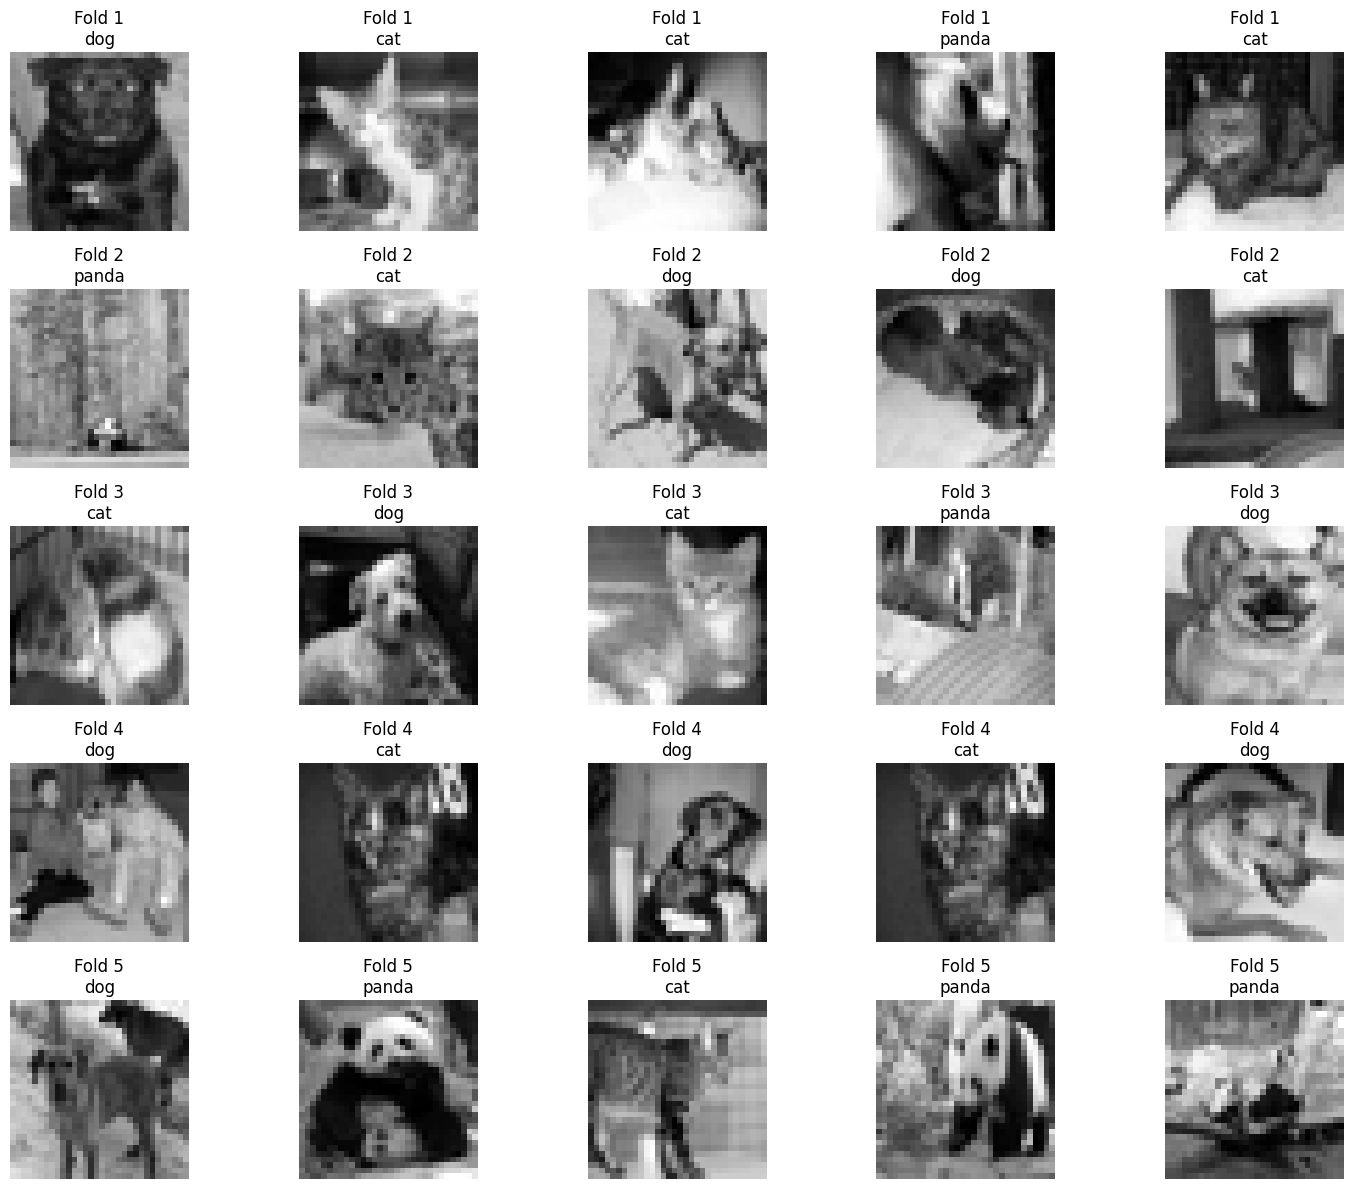

In [100]:
def create_folds(X, y, k=5):
    fold_size = len(X) // k
    folds_X = []
    folds_y = []

    for i in range(k):
        folds_X.append(X[i*fold_size:(i+1)*fold_size])
        folds_y.append(y[i*fold_size:(i+1)*fold_size])

    return folds_X, folds_y

folds_X, folds_y = create_folds(X, y)
print("5-folds created.")

plt.figure(figsize=(15, 12))

samples_per_fold = 5

for fold_idx in range(5):
    for i in range(samples_per_fold):

        idx = np.random.randint(0, len(folds_X[fold_idx]))
        img = folds_X[fold_idx][idx].reshape(32, 32)
        label = folds_y[fold_idx][idx]

        plt.subplot(5, samples_per_fold, fold_idx * samples_per_fold + i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Fold {fold_idx+1}\n{classes[label]}")
        plt.axis("off")

plt.tight_layout()
plt.show()



7.Distance Functions (L1 & L2)

In [101]:
def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))


8.KNN Implementation

In [102]:
def predict_knn(train_X, train_y, test_sample, K, distance_type="L1"):
    distances = []

    for i in range(len(train_X)):
        if distance_type == "L1":
            dist = manhattan_distance(test_sample, train_X[i])
        else:
            dist = euclidean_distance(test_sample, train_X[i])
        distances.append((dist, train_y[i]))

    distances = sorted(distances, key=lambda x: x[0])

    k_labels = [label for _, label in distances[:K]]
    counts = np.bincount(k_labels)
    return np.argmax(counts)


9. Evaluate Accuracy for One Fold

In [103]:
def evaluate_fold(train_X, train_y, test_X, test_y, K, distance_type):
    correct = 0
    for i in range(len(test_X)):
        pred = predict_knn(train_X, train_y, test_X[i], K, distance_type)
        if pred == test_y[i]:
            correct += 1
    return correct / len(test_y)#avoy


10. Evaluate All K Values Across All Folds

In [104]:
K_values = [1, 3, 5, 7, 9]

results_L1 = []
results_L2 = []

print("   FOLD-WISE ACCURACY TABLE")

for K in K_values:
    print(f"\n---------- K = {K} ----------")

    fold_acc_L1 = []
    fold_acc_L2 = []

    for i in range(5):

        print(f"\nFold {i+1}:")

        test_X = folds_X[i]
        test_y = folds_y[i]#avoy

        train_X = np.vstack([folds_X[j] for j in range(5) if j != i])
        train_y = np.hstack([folds_y[j] for j in range(5) if j != i])

        acc_L1 = evaluate_fold(train_X, train_y, test_X, test_y, K, "L1")
        acc_L2 = evaluate_fold(train_X, train_y, test_X, test_y, K, "L2")

        fold_acc_L1.append(acc_L1)
        fold_acc_L2.append(acc_L2)

        print(f"   L1 Accuracy = {acc_L1:.2f}%")
        print(f"   L2 Accuracy = {acc_L2:.2f}%")

    mean_L1 = np.mean(fold_acc_L1)
    mean_L2 = np.mean(fold_acc_L2)

    results_L1.append(mean_L1)
    results_L2.append(mean_L2)

    print(f"\n>>> Average L1 Accuracy for K={K}: {mean_L1:.2f}%")
    print(f">>> Average L2 Accuracy for K={K}: {mean_L2:.2f}%")
    print("---------------------------------------------")

print("\nFINAL MEAN RESULTS")
print("------------------------------")
print("L1 Mean Accuracies:", results_L1)
print("L2 Mean Accuracies:", results_L2)


   FOLD-WISE ACCURACY TABLE

---------- K = 1 ----------

Fold 1:
   L1 Accuracy = 0.36%
   L2 Accuracy = 0.27%

Fold 2:
   L1 Accuracy = 0.59%
   L2 Accuracy = 0.34%

Fold 3:
   L1 Accuracy = 0.34%
   L2 Accuracy = 0.31%

Fold 4:
   L1 Accuracy = 0.49%
   L2 Accuracy = 0.34%

Fold 5:
   L1 Accuracy = 0.34%
   L2 Accuracy = 0.31%

>>> Average L1 Accuracy for K=1: 0.42%
>>> Average L2 Accuracy for K=1: 0.31%
---------------------------------------------

---------- K = 3 ----------

Fold 1:
   L1 Accuracy = 0.37%
   L2 Accuracy = 0.25%

Fold 2:
   L1 Accuracy = 0.58%
   L2 Accuracy = 0.37%

Fold 3:
   L1 Accuracy = 0.41%
   L2 Accuracy = 0.34%

Fold 4:
   L1 Accuracy = 0.41%
   L2 Accuracy = 0.34%

Fold 5:
   L1 Accuracy = 0.31%
   L2 Accuracy = 0.31%

>>> Average L1 Accuracy for K=3: 0.41%
>>> Average L2 Accuracy for K=3: 0.32%
---------------------------------------------

---------- K = 5 ----------

Fold 1:
   L1 Accuracy = 0.34%
   L2 Accuracy = 0.24%

Fold 2:
   L1 Accuracy = 0.46

11. Plot Accuracy vs K

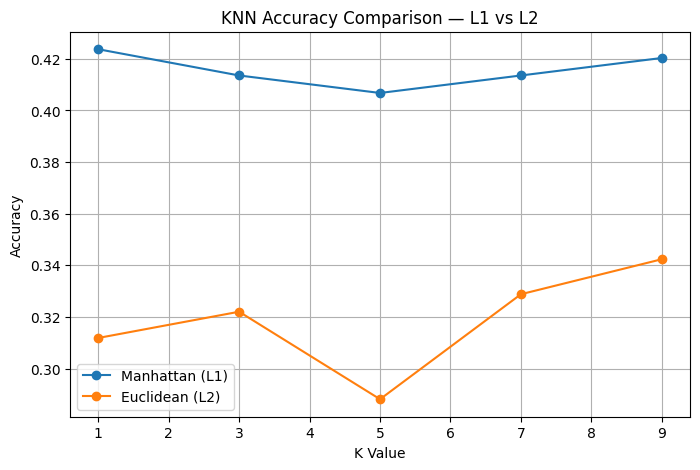

In [105]:
plt.figure(figsize=(8,5))
plt.plot(K_values, results_L1, marker='o', label="Manhattan (L1)")
plt.plot(K_values, results_L2, marker='o', label="Euclidean (L2)")

plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy Comparison — L1 vs L2")
plt.legend()
plt.grid(True)
plt.show()



#**Discussion**

Here I compared the performance of Manhattan (L1) and Euclidean (L2) distances based on the average accuracy values obtained from the 5-fold cross-validation. From the results, it is clear that the Manhattan (L1) distance performs consistently better than the Euclidean (L2) distance across all K values. This behavior can be explained by the characteristics of our dataset: the images are small (32×32), grayscale, and contain many small pixel-level variations. Because L2 distance squares the differences between pixels, it becomes more sensitive to noise and intensity fluctuations, which negatively affects performance. In contrast, L1 distance treats all pixel differences equally, making it more stable and better suited for this dataset.

I also observed that L1 achieves average accuracies between 40%–45%, while L2 remains lower, around 32%–34%. This suggests that for simple grayscale datasets with limited feature complexity, L1 provides a more reliable measure of similarity. However, both methods still struggle to achieve high accuracy, possibly due to small dataset size, class overlap, or the lack of feature extraction. Future improvements could include using feature engineering, dimensionality reduction (PCA), or switching to more advanced models such as CNNs to enhance the classification performance.

# 13. Show Top 5 Predictions

Top 5 Predictions (L1 & L2):



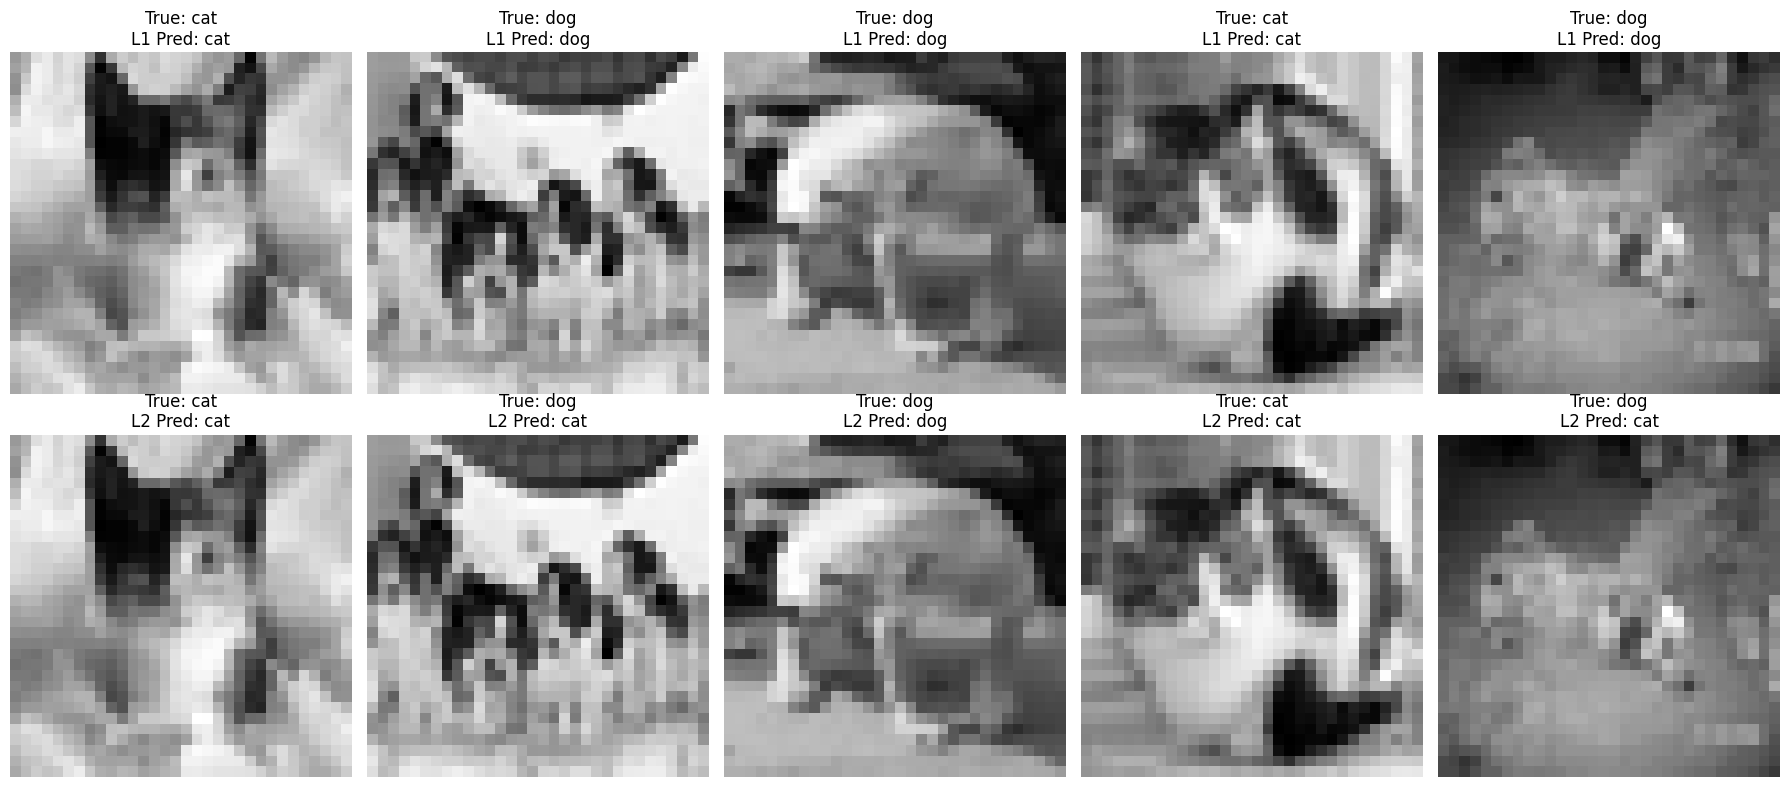


Accuracy (L1): 5/5 = 100.00%
Accuracy (L2): 3/5 = 60.00%


In [106]:
total = 5

correct_L1 = 0
correct_L2 = 0

plt.figure(figsize=(18, 8))

print("Top 5 Predictions (L1 & L2):\n")

for i in range(total):

    idx = random.randint(0, len(X)-1)
    img = X[idx]
    true_label = y[idx]

    pred_L1 = predict_knn(X, y, img, K=3, distance_type="L1")
    pred_L2 = predict_knn(X, y, img, K=3, distance_type="L2")

    if pred_L1 == true_label:
        correct_L1 += 1

    if pred_L2 == true_label:
        correct_L2 += 1

    plt.subplot(2, total, i+1)
    plt.imshow(img.reshape(32, 32), cmap="gray")#avoy
    plt.title(
        f"True: {classes[true_label]}\nL1 Pred: {classes[pred_L1]}"
    )
    plt.axis("off")

    plt.subplot(2, total, total+i+1)
    plt.imshow(img.reshape(32, 32), cmap="gray")
    plt.title(
        f"True: {classes[true_label]}\nL2 Pred: {classes[pred_L2]}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

# Accuracy
acc_L1 = (correct_L1 / total) * 100
acc_L2 = (correct_L2 / total) * 100

print(f"\nAccuracy (L1): {correct_L1}/{total} = {acc_L1:.2f}%")
print(f"Accuracy (L2): {correct_L2}/{total} = {acc_L2:.2f}%")
